In [1]:
import os
import warnings

# move directory to the root of this repo
os.chdir('\\'.join(os.getcwd().split('\\')[:-2]))
warnings.simplefilter("ignore")

import pandas as pd
import numpy as np
from simtag.filter import simtag_filter
from sklearn.neighbors import NearestNeighbors

In [2]:
tag_list = [x[1:] for x in open('wip/covariate-tagging/art_hashtags.txt').read().split('\n') if x.startswith('#')]
sample_list = [[tag_list[0]]]

In [3]:
# initiate engine
engine = simtag_filter(
    sample_list=sample_list,
    tag_list=tag_list,
    model_name='sentence-transformers/clip-ViT-B-32'
)
tag2index, indexed_sample_list = engine.index_samples(sample_list)

In [4]:
# if not existing, compute M
M, df_M = engine.compute_M(method='encoding')
# df_M.to_parquet('notebooks/steam-games/M.parquet')

# if existing, load M
# df_M = pd.read_parquet('notebooks/steam-games/M.parquet')

100%|██████████| 401/401 [00:12<00:00, 30.92it/s]


In [5]:
engine.load_M(df_M, covariate_transformation='dot_product')

### covariate tagging

In [38]:
from sentence_transformers.util import cos_sim
from collections import Counter
import random
import time
import textwrap
import matplotlib.pyplot as plt
from PIL import Image

def montecarlo_tagging(str1, top_tags=100, technique='scrolling_window', min_window=2, max_window=7, mc1=1000, top_mc1=20, score_threshold=0.01, verbose=False):
	startTime = time.time()
	# if verbose : print(textwrap.fill(str1, width=120))  # adjust the width to your liking
	if verbose: 
		
		# Calculate the new width to maintain aspect ratio
		width, height = str1.size
		aspect_ratio = width / height
		int1 = 300
		new_width = int(int1 * aspect_ratio)

		# Resize the image
		img2 = str1.resize((new_width, int1))
		display(img2)

	base_vector = engine.model.encode(str1)
	nbrs_tags = NearestNeighbors(n_neighbors=top_tags, metric='cosine').fit(df_M['vector_tags'].values.tolist())
	distances, indices = nbrs_tags.kneighbors([base_vector])
	indices = indices[0].tolist()
	top_tags = [engine.tag_list[x] for x in indices]
	# print(top_tags)
	top_tags

	if technique == 'scrolling_window':
		mc = list()
		for j in range(min_window, max_window+1):
			for k in range(int(len(top_tags)/j)+1):
				ranges = [k*j, (k+1)*j]
				choice = top_tags[ranges[0]:ranges[1]]
				if len(choice) > 0:
					mc.append(choice)
		mc_encoded = engine.encode_samples(mc, quantize_samples=False, show_progress=False)
		nbrs_mc = NearestNeighbors(n_neighbors=top_mc1, metric='cosine').fit(mc_encoded)
		distances, indices = nbrs_mc.kneighbors([engine.model.encode(str1)])

	elif technique == 'monte_carlo':
		mc = [list(set(random.choices(top_tags, k=random.randint(min_window, max_window)))) for x in range(mc1)]
		mc_encoded = engine.encode_samples(mc, quantize_samples=False, show_progress=False)
		nbrs_mc = NearestNeighbors(n_neighbors=top_mc1, metric='cosine').fit(mc_encoded)
		distances, indices = nbrs_mc.kneighbors([engine.model.encode(str1)])

	results = [mc[x] for x in indices[0]]
	top_tags = [x for xs in results for x in xs] # in case we want to pass it to the next monte-carlo
	# print(results[0:10])

	tag_freq = Counter(tag for game_tags in results for tag in game_tags)
	tag_freq = dict(tag_freq)
	# final_values = sorted([[sum([tag_freq[k] for k in x]), x] for x in results])[::-1][0][1]
	# final_values

	top_m = sorted([[tag_freq[key], key] for index, key in enumerate(tag_freq)])[::-1]
	# print(top_m)
	top_m = [x[1] for x in top_m]
	len(top_m)

	accepted = list()
	#
	best_selection_score = 0
	for m in range(len(top_m)):
		best_tag = ''
		score = 0
		for k in top_m:
			if k not in accepted:
				iteration = accepted + [k]
				vector_iteration = engine.encode_samples([iteration], quantize_samples=False, show_progress=False)[0]
				base_vector = base_vector.astype(vector_iteration.dtype)  # cast m2 to match m1's dtype
				vector_score = cos_sim(base_vector, vector_iteration).tolist()[0][0]
				if vector_score > score:
					score = vector_score
					best_tag = k
				else:
					pass
		sequence_score = score
		# print(sequence_score, best_selection_score, accepted)
		accepted.append(best_tag)

		if sequence_score > best_selection_score and m > 0 and ((sequence_score-best_selection_score)/best_selection_score) > score_threshold:
			best_selection_score = sequence_score
		elif m == 0:
			best_selection_score = sequence_score
		else:
			# print(sequence_score, best_selection_score, 'BREAK', accepted)
			break
			# pass

	endTime = time.time()
	howMuchTime = endTime - startTime

	if verbose : print('\nEXECUTION_TIME', round(howMuchTime, 4))

	return accepted

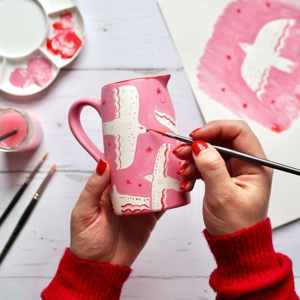


EXECUTION_TIME 0.3122


['PorcelainArt',
 'HandmadePottery',
 'CeramicsStudio',
 'Typography',
 'WatercolorArt']

In [45]:
import os

img_base = r'C:\Users\*****\Desktop\_projects\*****\sample-uploading\batch-uploading\_img_folder'
img_name = random.choice(os.listdir(img_base))
img_path = img_base + '\\' + img_name

accepted = montecarlo_tagging(Image.open(img_path), top_tags=100, technique='scrolling_window', min_window=3, max_window=10, score_threshold=0.001, verbose=True)
# [x.split('about: ')[1] for x in accepted]
accepted